In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import datasets
import transformers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.optimizers import Adam, RMSprop

from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Read the train.csv file
df = pd.read_csv('train.csv')

# Print the first and last five rows of the dataset
print("First five rows:")
print(df.head())
print("\nLast five rows:")
print(df.tail())

# Print the shape of the data
print("\nShape of the data:", df.shape)

# Print information about the columns in the dataset
print("\nColumn information:")
print(df.info())

# Check for missing values in any column
print("\nMissing values:")
print(df.isnull().sum())

# Print the number of unique values in each variable
print("\nNumber of unique values:")
print(df.nunique())


First five rows:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Last five rows:
         id keyword location  \
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UTC]?5km S of Volcano

Distribution of target variable:
 target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


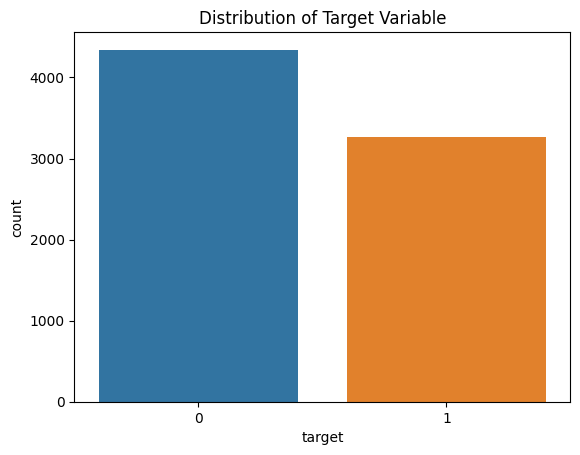

In [4]:
df = df.drop(['id', 'keyword', 'location'], axis=1)

# Use the distribution of the target variable to determine if, on average, a tweet tends to indicate a disaster or not
target_distribution = df['target'].value_counts(normalize=True)
print("Distribution of target variable:\n", target_distribution)

# Create a countplot to visualize the distribution of the target variable
sns.countplot(data=df, x='target')
plt.title('Distribution of Target Variable')
plt.show()

In [5]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Read the train.csv file
df = pd.read_csv('train.csv')

# Lowercase the text in the relevant column
df['text'] = df['text'].str.lower()

# Function to remove punctuations and numbers
def remove_punctuations_numbers(text):
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = ''.join(word for word in text if not word.isdigit())
    return text

# Apply punctuation and number removal function to the relevant column
df['text'] = df['text'].apply(remove_punctuations_numbers)

# Function to tokenize the text into individual words
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Apply tokenization function to the relevant column
df['tokens'] = df['text'].apply(tokenize_text)

# Function to remove stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    # Remove specific words from stopwords list if desired
    # stop_words.remove('specific_word')
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

# Apply stopword removal function to the relevant column
df['filtered_tokens'] = df['tokens'].apply(remove_stopwords)

# Create an instance of WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize words
def lemmatize_text(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

# Apply lemmatization function to the relevant column
df['lemmatized_tokens'] = df['filtered_tokens'].apply(lemmatize_text)

# Join lemmatized tokens into sentences
df['final'] = df['lemmatized_tokens'].apply(lambda x: ' '.join(x))

# Print the first five rows of the dataset
print(df.head())


   id keyword location                                               text  \
0   1     NaN      NaN  our deeds are the reason of this earthquake ma...   
1   4     NaN      NaN              forest fire near la ronge sask canada   
2   5     NaN      NaN  all residents asked to shelter in place are be...   
3   6     NaN      NaN   people receive wildfires evacuation orders in...   
4   7     NaN      NaN  just got sent this photo from ruby alaska as s...   

   target                                             tokens  \
0       1  [our, deeds, are, the, reason, of, this, earth...   
1       1      [forest, fire, near, la, ronge, sask, canada]   
2       1  [all, residents, asked, to, shelter, in, place...   
3       1  [people, receive, wildfires, evacuation, order...   
4       1  [just, got, sent, this, photo, from, ruby, ala...   

                                     filtered_tokens  \
0  [deeds, reason, earthquake, may, allah, forgiv...   
1      [forest, fire, near, la, ronge, s

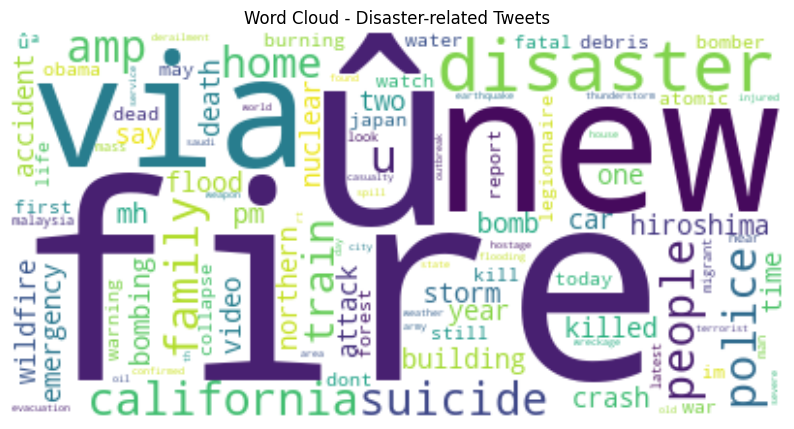

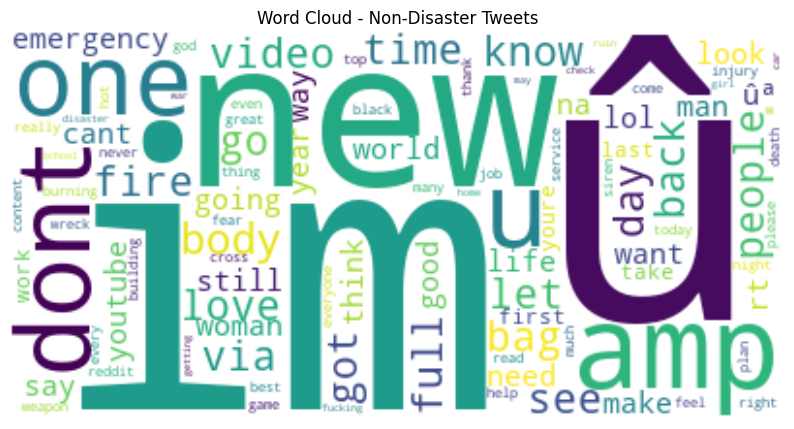

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Filter the dataframe to include only tweets indicating a disaster
disaster_df = df[df['target'] == 1]

# Create a WordCloud object for disaster-related tweets
wordcloud_disaster = WordCloud(max_words=100, random_state=42, background_color='white', collocations=False)

# Generate the WordCloud for disaster-related tweets
wordcloud_disaster.generate(' '.join(disaster_df['final']))

# Create and display the plot for disaster-related tweets
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Word Cloud - Disaster-related Tweets')
plt.axis('off')
plt.show()

# Create a new dataframe for non-disaster tweets
non_disaster_df = df[df['target'] == 0]

# Create a WordCloud object for non-disaster tweets
wordcloud_non_disaster = WordCloud(max_words=100, random_state=42, background_color='white', collocations=False)

# Generate the WordCloud for non-disaster tweets
wordcloud_non_disaster.generate(' '.join(non_disaster_df['final']))

# Create and display the plot for non-disaster tweets
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Word Cloud - Non-Disaster Tweets')
plt.axis('off')
plt.show()


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TextVectorization, Embedding, Dense
from tensorflow.keras.optimizers import Adam

# Create arrays for target and predictor variables
target = df['target'].values
predictors = df['final'].values

# Decide the proportion of the dataset for training
train_ratio = 0.8

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors, target, train_size=train_ratio, random_state=42)

# Create the vectorizer layer
vectorizer = TextVectorization(max_tokens=1000, output_mode='int', output_sequence_length=100)
vectorizer.adapt(np.concatenate((X_train, X_test)))

# Vectorize the training and test sets
X_train = vectorizer(X_train).numpy()
X_test = vectorizer(X_test).numpy()

# Create the model
model = Sequential()
model.add(Input(shape=(100,), dtype=tf.int64))
model.add(Embedding(len(vectorizer.get_vocabulary()) + 1, 128, input_length=100))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(X_test, y_test)

print('Test Loss:', loss)
print('Test Accuracy:', accuracy)


Epoch 1/10


ValueError: in user code:

    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/src/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/src/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/src/losses.py", line 2432, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/src/backend.py", line 5809, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 100, 1) vs (None,)).
